In [159]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


In [ ]:
data_files = glob.glob("..\\data\\*.csv")
data_files

In [160]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [ ]:
def seasonal_analyze(data, name, save_file_name, period, time_flag, model, save=False):
    base_path = f"../out/img/{name}"
    seasonal_path = f"{base_path}/seasonal"
    fourier_path = f"{base_path}/fourier"
    os.makedirs(seasonal_path, exist_ok=True)
    os.makedirs(fourier_path, exist_ok=True)

    plt.figure(figsize=(15, 6.4))
    plt.plot(data, linestyle="-", label=f"{'' if name == 'CPI' else 'CPI of'} {name}")
    plt.title(name)
    plt.legend()
    if save: plt.savefig(f"{base_path}/{save_file_name}")
    plt.show()


    season = seasonal_decompose(data, model=model, period=period)
    season.plot().set_size_inches(10, 6.4)
    plt.tight_layout()
    if save:
        plt.savefig(f"{seasonal_path}/{save_file_name}")
    plt.show()

    n = len(data)
    fourier_result = np.fft.fft(data.values)
    fourier_freq = np.abs(np.fft.fftfreq(len(fourier_result)))
    power_spectrum = np.abs(fourier_result) ** 2
    nonzero_power_spectrum = power_spectrum[1:]
    dominant_freq_index = np.argmax(nonzero_power_spectrum) + 1
    dominant_frequency = fourier_freq[dominant_freq_index]
    dominant_period = 1 / dominant_frequency
    peak_freq = fourier_freq[dominant_freq_index]
    peak_power = power_spectrum[dominant_freq_index]


    plt.title(f"Fourier Transform of {name} in {time_flag}")
    plt.xlabel("Frequency (cycles/year)")
    plt.ylabel("Magnitude")
    plt.plot(fourier_freq[: n // 2], power_spectrum[: n // 2], label="Power Spectrum")
    
    plt.plot(peak_freq, peak_power, 'ro')  # Red dot
    plt.text(
        peak_freq,
        peak_power,
        f'Peak\nFrequency: {peak_freq:.4f}\nPeriod: {dominant_period:.2f} months',
        color='red',
        ha='center',
        va='bottom'
    )
    plt.tight_layout()
    if save:
        plt.savefig(f"{fourier_path}/{save_file_name}")
    plt.show()

    plot_acf(data)
    plot_pacf(data)

In [ ]:
def read_data(filename):
    df = pd.read_csv(filename)
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%Y')
    df.set_index('Date', inplace=True)

    name = os.path.splitext(os.path.basename(filename))[0]

    return df, name

    

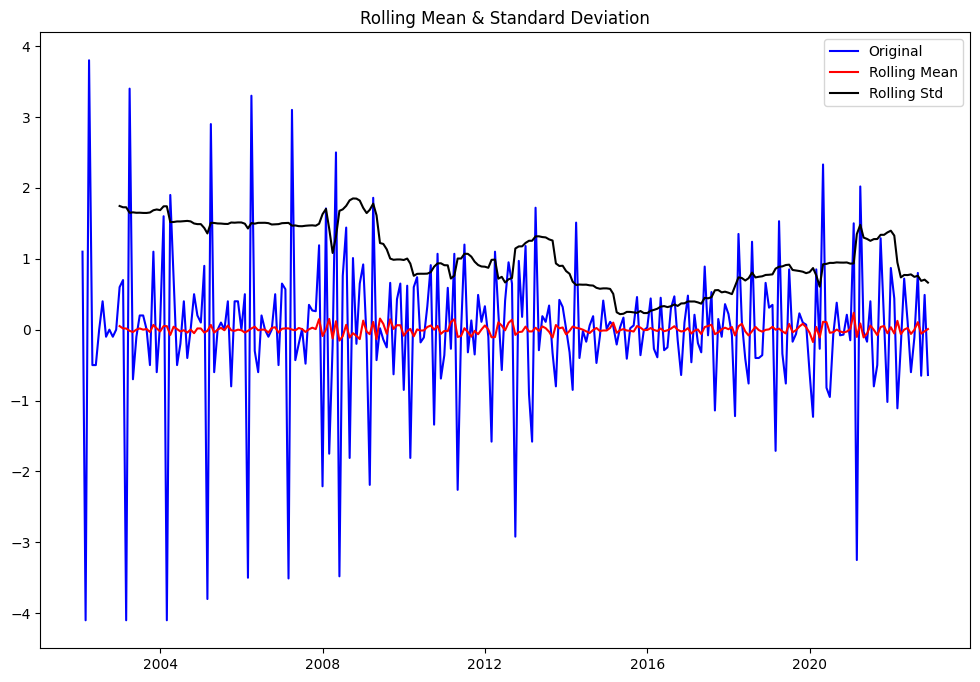

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.653304e+00
p-value                        1.765759e-11
#Lags Used                     1.700000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


In [162]:
df, name = read_data("../data/CPI.csv")
temp = df['Change'].copy()
for _ in range(0):
    temp = temp.diff()
    temp = temp.dropna()
test_stationarity(temp)

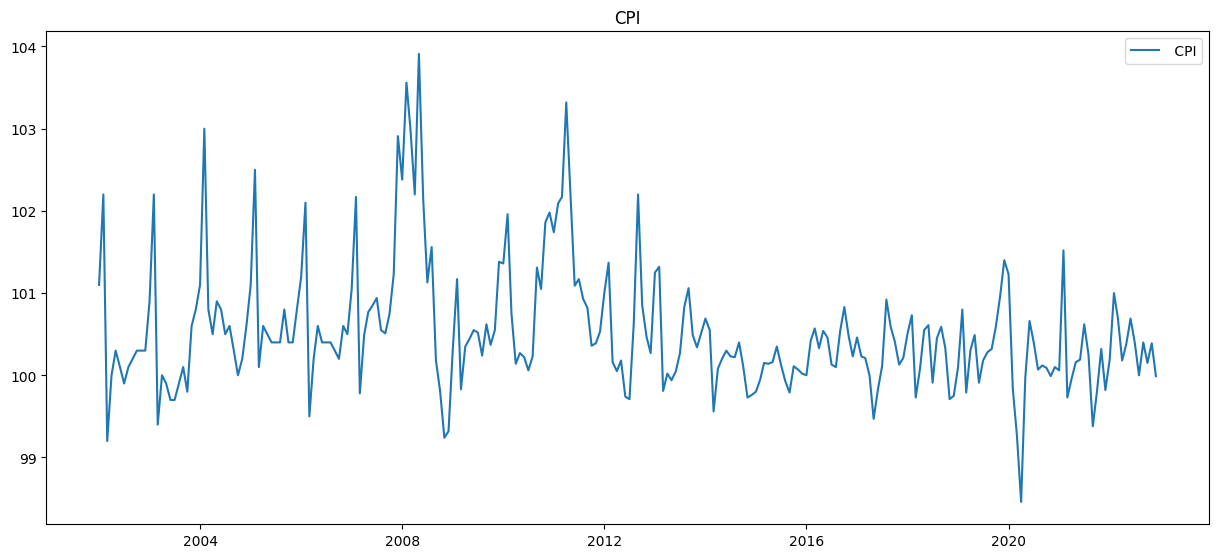

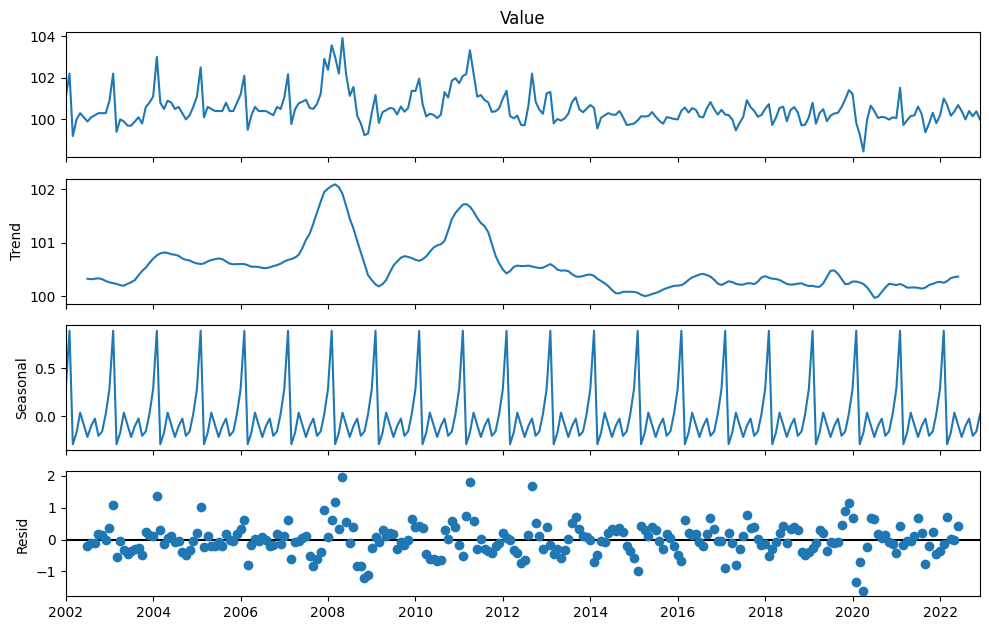

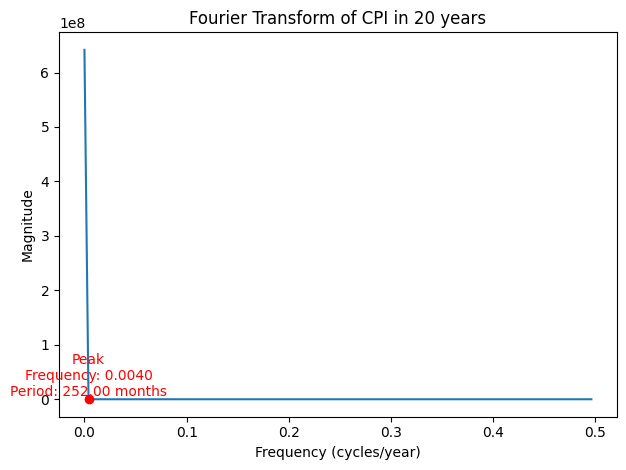

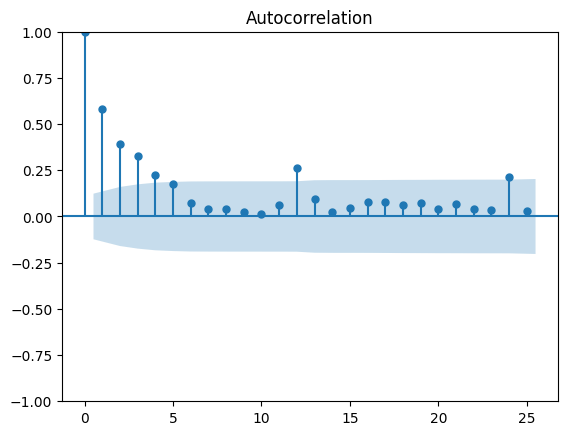

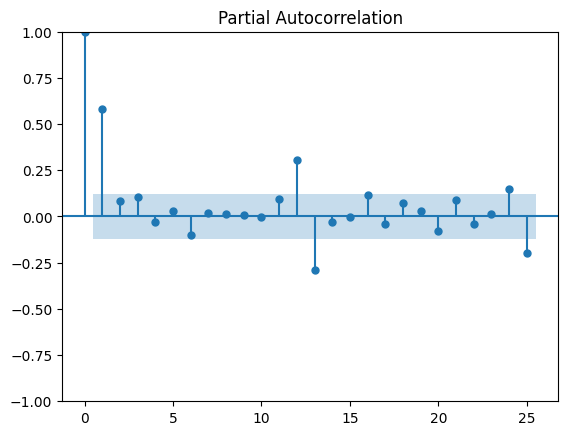

In [154]:
debug = seasonal_analyze(df["Value"], name, "20years", period=12, time_flag="20 years", model="additive")
debug